### Importing necessary modules

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import csv
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Download the colors dataset
if not os.path.exists('colors.csv'):
  !curl -O 'https://raw.githubusercontent.com/random-forests/datasets/master/colors.csv'
!head colors.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  323k  100  323k    0     0   356k      0 --:--:-- --:--:-- --:--:--  356k
name,red,green,blue
parakeet,174,182,87
saddle brown,88,52,1
cucumber crush,222,237,215
pool blue,134,194,201
distance,98,110,130
light urple,179,111,246
east side,172,145,206
florida seashells,250,228,199
paris,145,167,189


### Preparing the Data

In [3]:
# Read the data
colors_rgb = []
csv_reader = csv.reader(open('colors.csv'), delimiter=',')
next(csv_reader) # Remove the header
for row in csv_reader:
    name, r, g, b = row[0].lower().strip(), float(row[1]) / 255.0, float(row[2]) / 255.0, float(row[3]) / 255.0
    colors_rgb.append((name, r, g, b))
print(len(colors_rgb), 'colors downloaded')
print('For example', colors_rgb[0])

14157 colors downloaded
For example ('parakeet', 0.6823529411764706, 0.7137254901960784, 0.3411764705882353)


In [0]:
names = [item[0] for item in colors_rgb]

### Tokenizing the colors at a character level

In [0]:
maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
padded_names = pad_sequences(tokenized, maxlen=maxlen)
padded_names = padded_names.astype('float32')

In [0]:
r = [item[1] for item in colors_rgb]
g = [item[2] for item in colors_rgb]
b = [item[3] for item in colors_rgb]
targets = np.column_stack([r, g, b])

### Splitting into train and test

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
x_train, x_test, y_train, y_test = train_test_split(padded_names, targets, test_size=0.2, random_state=42)

### Using GRUs in the model

In [65]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((1, maxlen), input_shape=(maxlen,)))
model.add(tf.keras.layers.CuDNNGRU(128, return_sequences=True))
model.add(tf.keras.layers.CuDNNGRU(128, return_sequences=True))
model.add(tf.keras.layers.CuDNNGRU(128))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='sigmoid'))
model.compile(optimizer=tf.train.AdamOptimizer(), loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 1, 25)             0         
_________________________________________________________________
cu_dnngru (CuDNNGRU)         (None, 1, 128)            59520     
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 1, 128)            99072     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 195       
Total params: 266,115
Trainable params: 266,115
Non-trainable params: 0
_________________________________________________________________


In [80]:
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
284/284 [==============================] - 13s 45ms/step - loss: 0.0507 - val_loss: 0.0513
Epoch 2/10
284/284 [==============================] - 13s 45ms/step - loss: 0.0490 - val_loss: 0.0498
Epoch 3/10
284/284 [==============================] - 13s 45ms/step - loss: 0.0474 - val_loss: 0.0505
Epoch 4/10
284/284 [==============================] - 13s 45ms/step - loss: 0.0461 - val_loss: 0.0518
Epoch 5/10
284/284 [==============================] - 13s 45ms/step - loss: 0.0446 - val_loss: 0.0512
Epoch 6/10
284/284 [==============================] - 13s 45ms/step - loss: 0.0431 - val_loss: 0.0522
Epoch 7/10
284/284 [==============================] - 13s 45ms/step - loss: 0.0420 - val_loss: 0.0530
Epoch 8/10
284/284 [==============================] - 13s 45ms/step - loss: 0.0406 - val_loss: 0.0538
Epoch 9/10
284/284 [==============================] - 13s 45ms/step - loss: 0.0393 - val_loss: 0.0544
Epoch 10/10
284/284 [==============================] - 13s 45ms/step - loss: 0.037

In [0]:
def plot_history(histories, key):
  plt.figure(figsize=(20,10))
    
  for name, history in histories:
    val = plt.plot([x+1 for x in history.epoch], history.history['val_'+key], '--', label=name.title()+' Val')
    plt.plot([x+1 for x in history.epoch], history.history[key], color=val[0].get_color(), label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.xticks([x+1 for x in history.epoch])
  plt.ylabel(key.replace('_',' ').title())
  plt.title('Plot of '+ name.title() +' at different Epochs', fontsize=18)
  plt.legend()

### Plotting the Loss

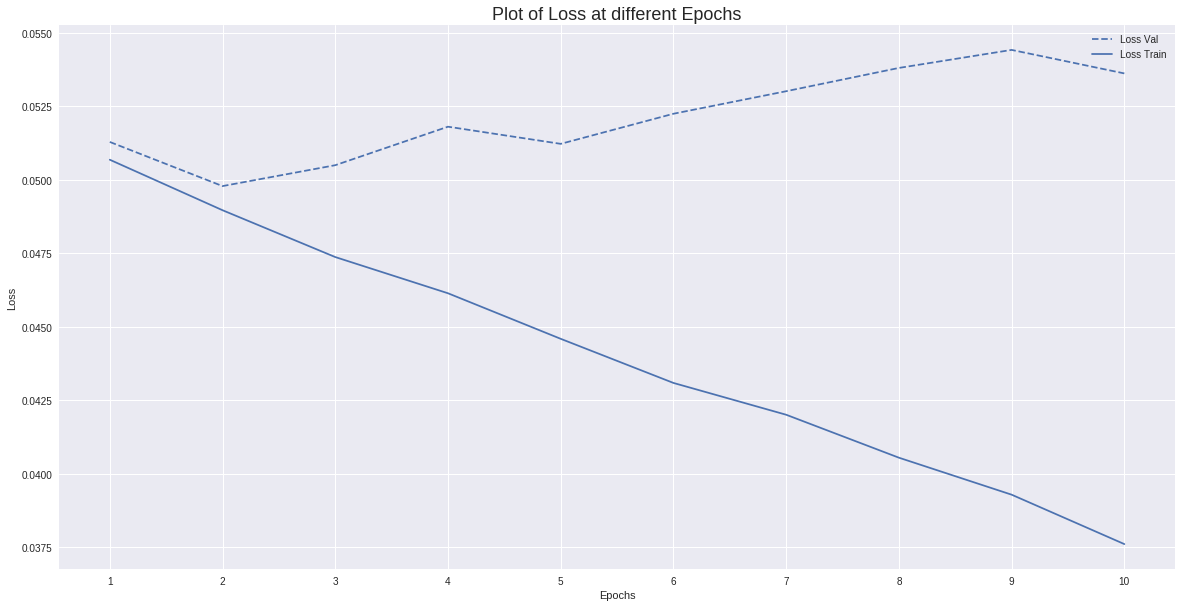

In [82]:
plot_history([('Loss', history)],  key='loss')

### Evaluating the Loss on test data

In [83]:
loss = model.evaluate(x_test, y_test)
print('Model Test Loss: {0:.4f}'.format(loss))

89/89 [==============================] - 1s 16ms/step
Model Test Loss: 0.0537


In [0]:
# plots a color image
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [0]:
def scale(n):
    return int(n * 255)

In [0]:
def predict(name):
    tokenized = t.texts_to_sequences([name])
    padded = pad_sequences(tokenized, maxlen=maxlen)
    padded = padded.astype('float32')
    pred = model.predict(np.array(padded))[0]
    # Check the shapes here if you run into trouble with the next 
    # method after adding your RNN
    print(pred)
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

### Testing predictions on some colors

[0.32312134 0.5727745  0.75932944]
light blue, R,G,B: 82 146 193


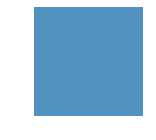

[0.36219075 0.650032   0.76090634]
blue, R,G,B: 92 165 194


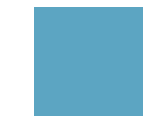

[0.28694594 0.32769135 0.5036263 ]
dark blue, R,G,B: 73 83 128


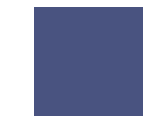

[0.84453964 0.4880915  0.18548326]
tangerine, R,G,B: 215 124 47


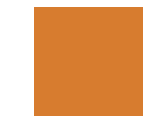

[0.11832191 0.20962916 0.39077735]
navy blue, R,G,B: 30 53 99


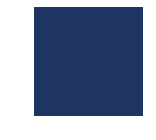

[0.57000726 0.24495284 0.44310468]
magenta, R,G,B: 145 62 112


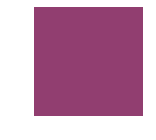

[0.5648049  0.28986153 0.4051396 ]
purple, R,G,B: 144 73 103


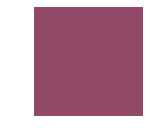

[0.6913079  0.19672644 0.16736057]
dark red, R,G,B: 176 50 42


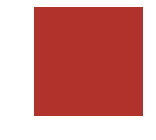

[0.7575182  0.6791128  0.26652196]
dark yellow, R,G,B: 193 173 67


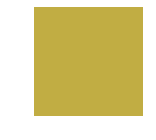

[0.8178888  0.53541315 0.5629326 ]
baby pink, R,G,B: 208 136 143


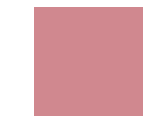

In [87]:
# some "test" data
predict("light blue")
predict("blue")
predict("dark blue")
predict("tangerine")
predict("navy blue")
predict("magenta")
predict("purple")
predict("dark red")
predict("dark yellow")
predict("baby pink")

### Model seems to be doing decently well on the colors predicted above